# Import

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from random import randrange
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical


Using TensorFlow backend.


<h1 style="text-align: center;"> EMNIST </h1>

# Preprocessing

In [2]:
# Import data 
# Note that both the uppercase and lowercase variants of a single letter belong to the same class
data = pd.read_csv("data/emnist-letters.csv")
ys_real = data.iloc[:,0].values - 1
Xs_real = data.iloc[:,1:].values

# Some constants and parameters
N_SAMPLES = data.shape[0]
N_CLASSES = len(np.unique(ys_real))
IMAGE_SIZE = 28

# Normalize pixels' values between -1 and 1, and reshape the images
Xs_real = -1 + 2 * (Xs_real / np.max(Xs_real))
Xs_real = Xs_real.reshape(N_SAMPLES, IMAGE_SIZE, IMAGE_SIZE)
for i in range(N_SAMPLES):
    Xs_real[i] = Xs_real[i].T
Xs_real = Xs_real.reshape(N_SAMPLES, IMAGE_SIZE, IMAGE_SIZE, 1)
    
# Create a map from labels to their corresponding English letters
letters = [chr(i) for i in range(65, 91)]
letters_map = {index: letter for (index, letter) in enumerate(letters)}
print(letters_map)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


Sample 6989, Letter B


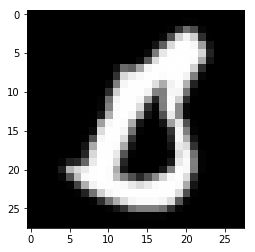

In [3]:
# Pick a random image from the data and show 
index = randrange(N_SAMPLES)
image = Xs_real[index].reshape(IMAGE_SIZE, IMAGE_SIZE)
letter = letters_map[ys_real[index]]
print("Sample %d, Letter %s" % (index, letter))
plt.imshow(image, cmap="gray")
plt.show()

# Models

In [4]:
Z_DIMENSION = 100
y_input = Input(shape=(N_CLASSES,))
Z_input = Input(shape=(Z_DIMENSION,))
X_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

In [5]:
def get_generator(Z_input, y_input):
    """
    @param Z_dim: input tensor for the noise vector Z.
    @param y_dim: input tensor for the conditional vector y, with dimensionality equal to number of classes
                  (since y is the one-hot-encoded vector representing which class we want to generate).
    """
    concatenated_input = Concatenate()([Z_input, y_input])
    layer = Dense(128*7*7)(concatenated_input)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    layer = Reshape((7,7,128))(layer)
    
    layer = UpSampling2D(size=2)(layer)
    layer = Conv2DTranspose(64, kernel_size=3, strides=1, padding="same")(layer)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    
    layer = Conv2DTranspose(32, kernel_size=3, strides=1, padding="same")(layer)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    
    layer = Conv2DTranspose(16, kernel_size=3, strides=1, padding="same")(layer)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    
    layer = UpSampling2D(size=2)(layer)
    layer = Conv2DTranspose(1, kernel_size=3, strides=1, padding="same")(layer)
    layer = Activation("tanh")(layer)
    model = Model(inputs=[Z_input, y_input], outputs=layer)
    return model

G = get_generator(Z_input, y_input)
G.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 126)          0           input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6272)         796544      concatenate_1[0][0]              
__________

In [6]:
def get_discriminator(X_input, y_input):
    """
    @param X_input: input tensor for the actual image X.
    @param y_input: input tensor for the conditional vector y, with dimensionality equal to number of classes
                    (since y is the one-hot-encoded vector representing which class we want to generate).
    """
    
    layer = Conv2D(128, kernel_size=5, strides=2, padding="same")(X_input)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)

    layer = Flatten()(layer)
    layer = Concatenate()([layer, y_input])
    
    layer = Dense(256)(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.4)(layer)
    layer = Activation("relu")(layer)
    
    layer = Dense(128)(layer)
    layer = Dropout(0.25)(layer)
    layer = Activation("relu")(layer)
    
    layer = Dense(1)(layer)
    layer = Activation("sigmoid")(layer)
    model = Model(inputs=[X_input, y_input], outputs=layer)
    return model

opt = Adam(0.002, 0.5)
D = get_discriminator(X_input, y_input)
D.compile(loss="binary_crossentropy", optimizer=opt)
D.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 128)  3328        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 14, 14, 128)  512         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 14, 14, 128)  0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
flatten_1 

In [7]:
def get_cgan():
    D.trainable = False # freeze discriminator so that only generator is trained
    X_tensor = G([Z_input, y_input])
    output = D([X_tensor, y_input])
    model = Model(inputs=[Z_input, y_input], outputs=output)
    return model

opt = Adam(0.002, 0.5)
cgan = get_cgan()
cgan.compile(loss="binary_crossentropy", optimizer=opt)
cgan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28, 1)    919105      input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            6467329     model_1[1][0]                    
          

# Utililities

In [8]:
N_ROWS = 5
N_COLS = 10
N_EPOCHS = 40
BATCH_SIZE = 64
N_BATCHES = math.ceil(N_SAMPLES/BATCH_SIZE)
IMAGES_PATH = "images/"
MODELS_PATH = "models/"
if not os.path.exists(IMAGES_PATH): os.mkdir(IMAGES_PATH)
if not os.path.exists(MODELS_PATH): os.mkdir(MODELS_PATH)

In [9]:
def onehot_encoding(ys):
    onehot = [to_categorical(y, N_CLASSES) for y in ys]
    return np.array(onehot)

def generate_random_Z_noise(numSamples):
    return np.random.normal(0.0, 1.0, size=(numSamples, Z_DIMENSION))

def generate_random_conditions(numSamples):
    return np.random.choice(N_CLASSES, numSamples)

def generate_labels(image_type, flipped_ratio):
    if image_type == "real":
        labels = np.random.uniform(0.9, 1.0, size=(BATCH_SIZE, 1))
    elif image_type == "fake":
        labels = np.random.uniform(0.0, 0.1, size=(BATCH_SIZE, 1))
    flipped_indices = np.random.choice(BATCH_SIZE, size=int(flipped_ratio*BATCH_SIZE))
    labels[flipped_indices] = 1 - labels[flipped_indices]
    return labels

def show_images(epoch, images, conditions):
    targets = [letters_map[c] for c in conditions]
    fig = plt.figure(figsize=(10, 5))
    plt.subplots_adjust(bottom=0, top=1)
    
    for index in range(N_ROWS*N_COLS):
        plt.subplot(N_ROWS, N_COLS, index+1)
        image = images[index].reshape(IMAGE_SIZE, IMAGE_SIZE)
        plt.imshow(image, cmap="gray")
        plt.title(targets[index])
        plt.axis("off")
    plt.savefig(IMAGES_PATH + "epoch" + str(epoch) + ".png")
    plt.show()

def show_progress(epoch):
    numSamples = N_ROWS*N_COLS
    Z_noise = generate_random_Z_noise(numSamples)
    conditions = generate_random_conditions(numSamples)
    onehot_conditions = onehot_encoding(conditions)
    images = G.predict([Z_noise, onehot_conditions])
    show_images(epoch, images, conditions)
    
def save_progress(epoch):
    G.save(MODELS_PATH + "G_epoch" + str(epoch) + ".h5")
    D.save(MODELS_PATH + "D_epoch" + str(epoch) + ".h5")
    

# Training

/home/student/anaconda3/envs/dml_gpu/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0, G-Loss: 0.8151143158890672, D-Loss-Real: 0.6304824426555496, D-Loss-Fake: 0.635740336127343


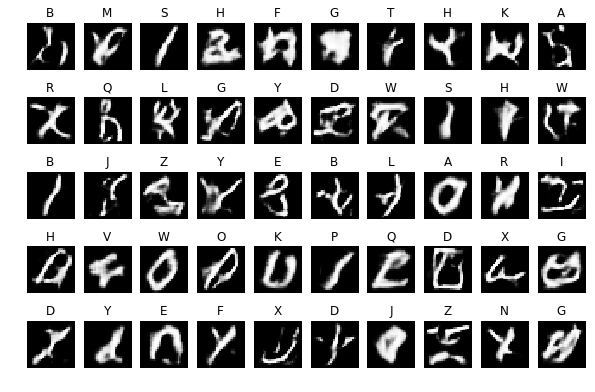

Epoch: 1, G-Loss: 0.9922743859762589, D-Loss-Real: 0.5733113303265241, D-Loss-Fake: 0.5560183279023047


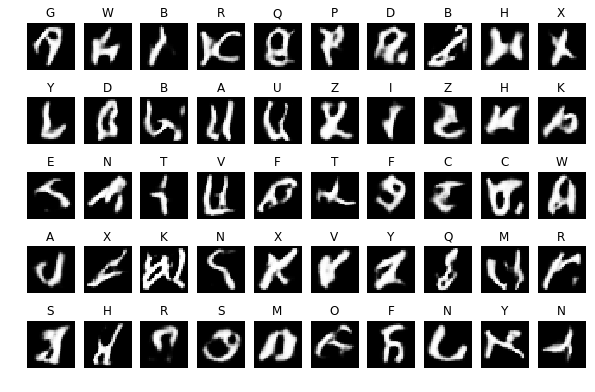

Epoch: 2, G-Loss: 0.9391184507598107, D-Loss-Real: 0.6057577240750495, D-Loss-Fake: 0.5897632088157904


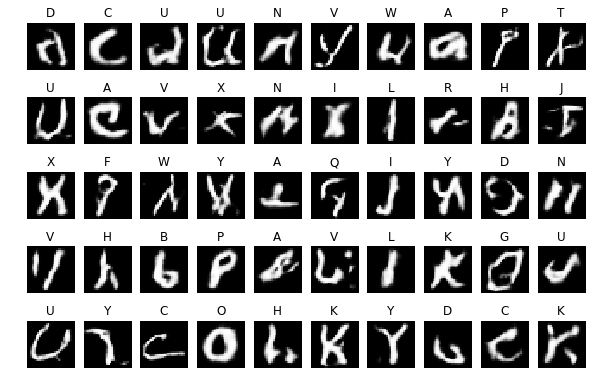

Epoch: 3, G-Loss: 0.9385456755456733, D-Loss-Real: 0.619738547211937, D-Loss-Fake: 0.6066280136190849


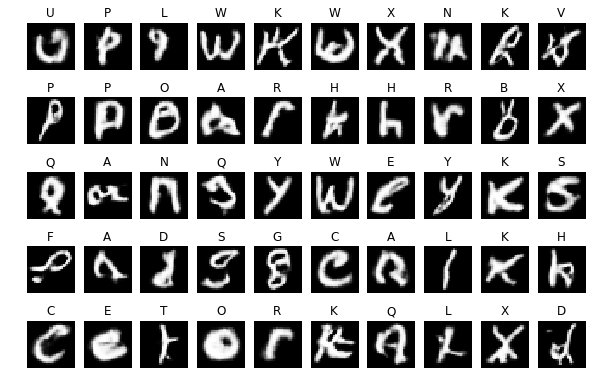

Epoch: 4, G-Loss: 0.9741095126276401, D-Loss-Real: 0.6106880689818165, D-Loss-Fake: 0.5985636940435305


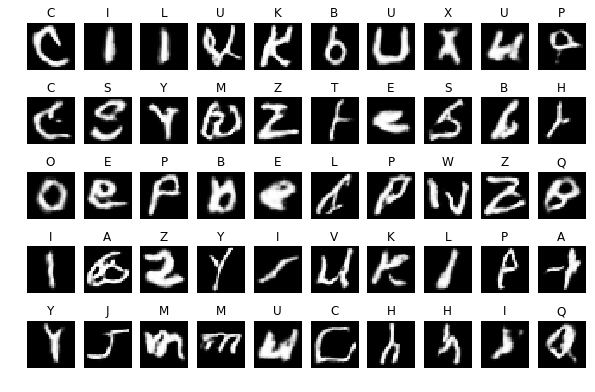

Epoch: 5, G-Loss: 1.0426351790039958, D-Loss-Real: 0.6045422917741864, D-Loss-Fake: 0.5853821653926407


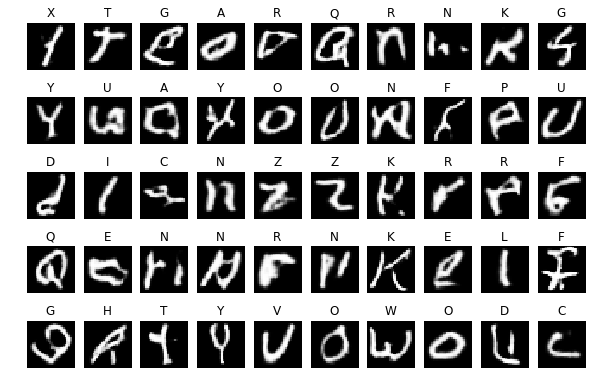

Epoch: 6, G-Loss: 1.0917058055442073, D-Loss-Real: 0.597295501712248, D-Loss-Fake: 0.5784937072684854


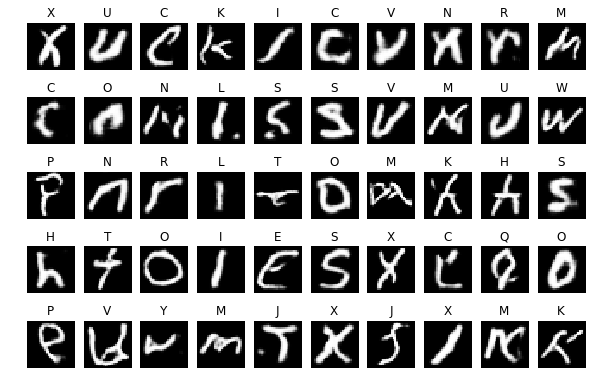

Epoch: 7, G-Loss: 1.1274526057823935, D-Loss-Real: 0.5906474552297111, D-Loss-Fake: 0.5699899598569622


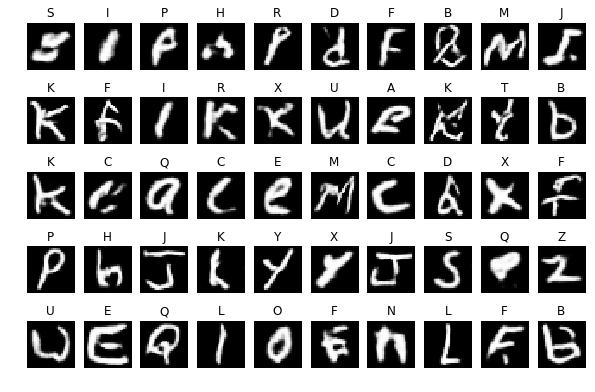

Epoch: 8, G-Loss: 1.1634466466024218, D-Loss-Real: 0.5829852583901339, D-Loss-Fake: 0.5617110235589725


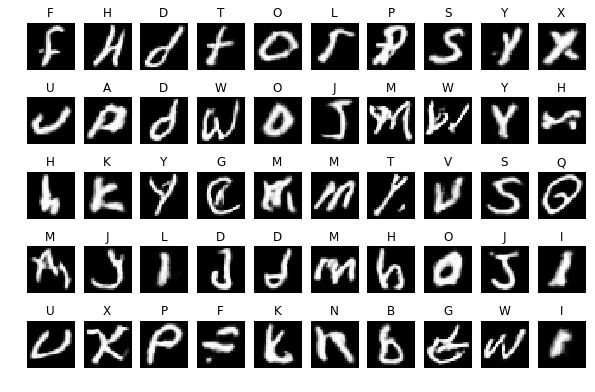

Epoch: 9, G-Loss: 1.1769433467721389, D-Loss-Real: 0.5792223916144811, D-Loss-Fake: 0.5572418280010265


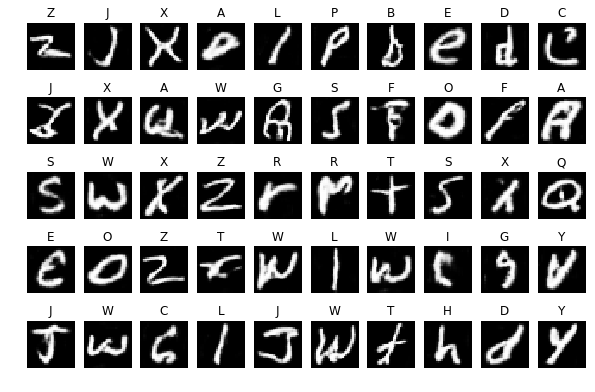

Epoch: 10, G-Loss: 1.196716724151493, D-Loss-Real: 0.5735900865422202, D-Loss-Fake: 0.5547730291654123


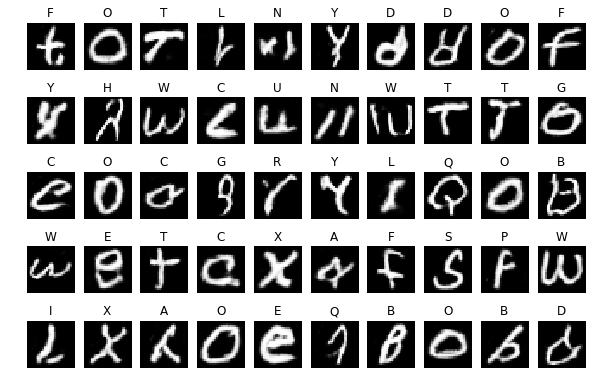

Epoch: 11, G-Loss: 1.228188447332176, D-Loss-Real: 0.5712414446155345, D-Loss-Fake: 0.550670825309987


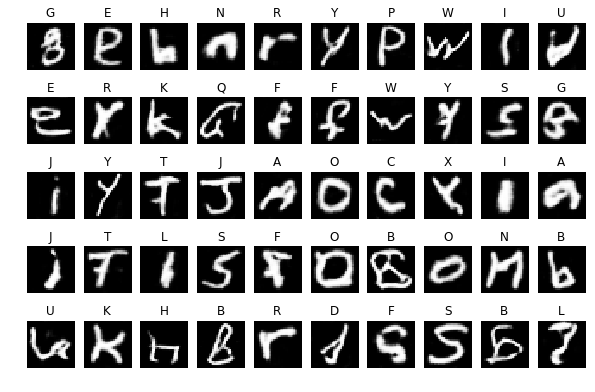

Epoch: 12, G-Loss: 1.2517078073120942, D-Loss-Real: 0.5646454292518605, D-Loss-Fake: 0.5432420039511895


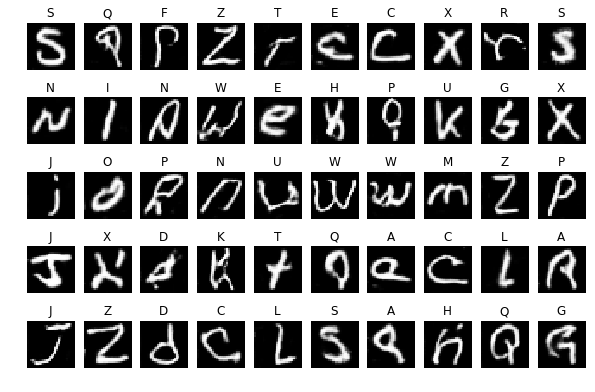

Epoch: 13, G-Loss: 1.2844243199062622, D-Loss-Real: 0.5586079224214087, D-Loss-Fake: 0.5375901590120208


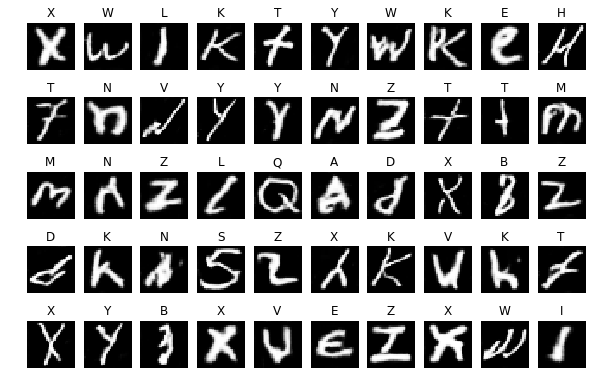

Epoch: 14, G-Loss: 1.2948175488356555, D-Loss-Real: 0.5544265765235129, D-Loss-Fake: 0.5340818188204202


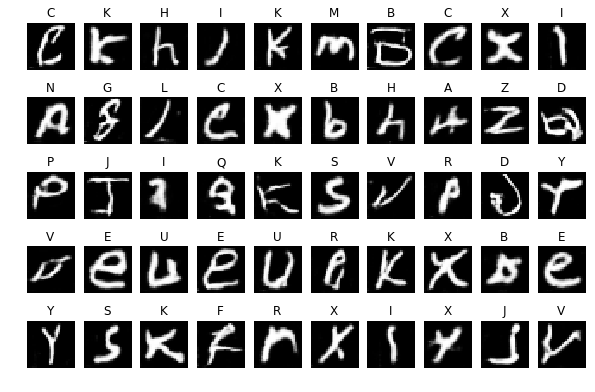

Epoch: 15, G-Loss: 1.3107044104196839, D-Loss-Real: 0.5497549468656782, D-Loss-Fake: 0.5321132145199378


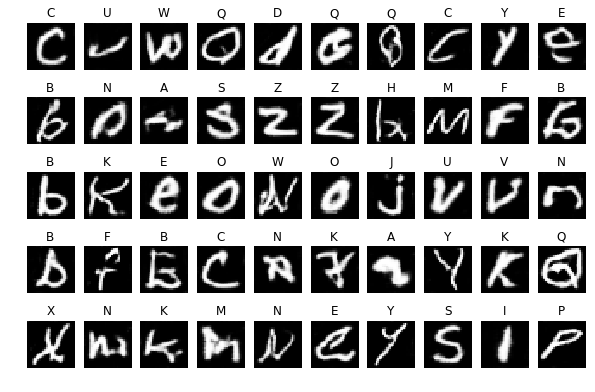

Epoch: 16, G-Loss: 1.3237969569582761, D-Loss-Real: 0.5498821653361279, D-Loss-Fake: 0.5262749534776644


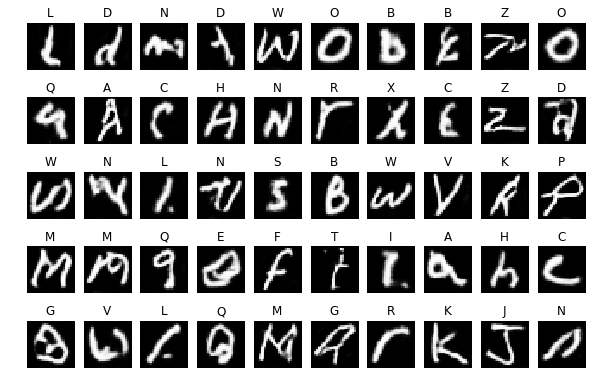

Epoch: 17, G-Loss: 1.354658675382735, D-Loss-Real: 0.5421495218828364, D-Loss-Fake: 0.523735672342846


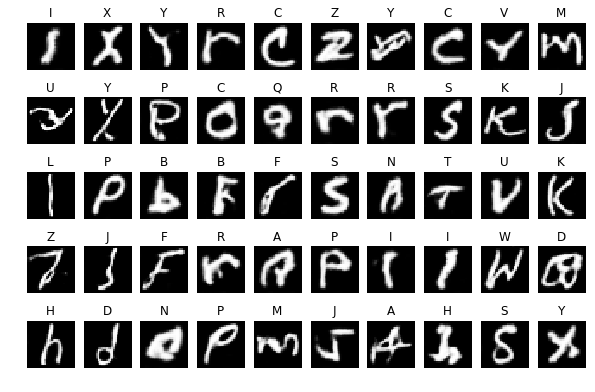

Epoch: 18, G-Loss: 1.3659029785082044, D-Loss-Real: 0.5382437007957989, D-Loss-Fake: 0.5206888002646759


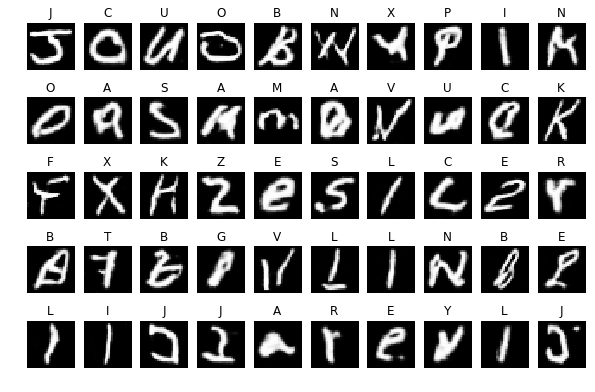

Epoch: 19, G-Loss: 1.3746552174476108, D-Loss-Real: 0.5359765514301978, D-Loss-Fake: 0.5167816102032359


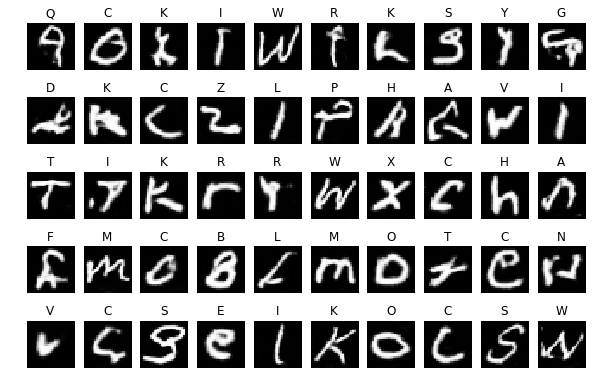

Epoch: 20, G-Loss: 1.3960126063837441, D-Loss-Real: 0.5339361971152963, D-Loss-Fake: 0.5149196320205326


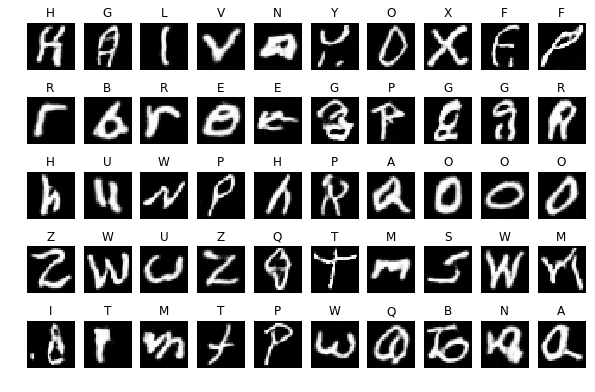

Epoch: 21, G-Loss: 1.4275598090560704, D-Loss-Real: 0.5279213317833648, D-Loss-Fake: 0.5079593679489252


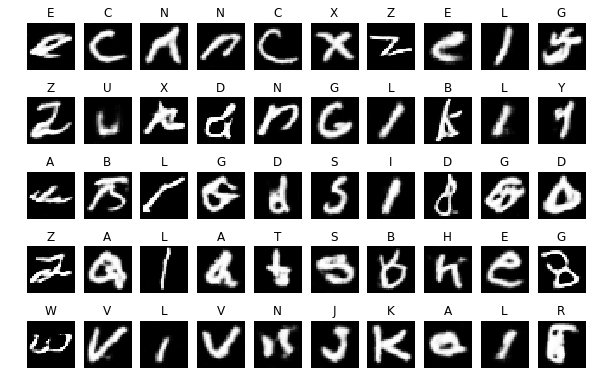

Epoch: 22, G-Loss: 1.4334454242709047, D-Loss-Real: 0.5263627594503271, D-Loss-Fake: 0.5071935762761306


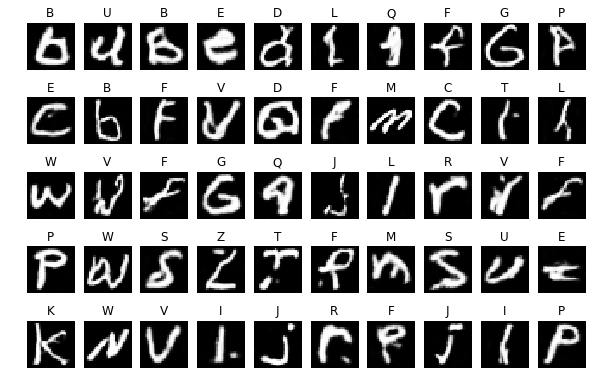

Epoch: 23, G-Loss: 1.4391952636262526, D-Loss-Real: 0.5233235853249126, D-Loss-Fake: 0.5063194513793294


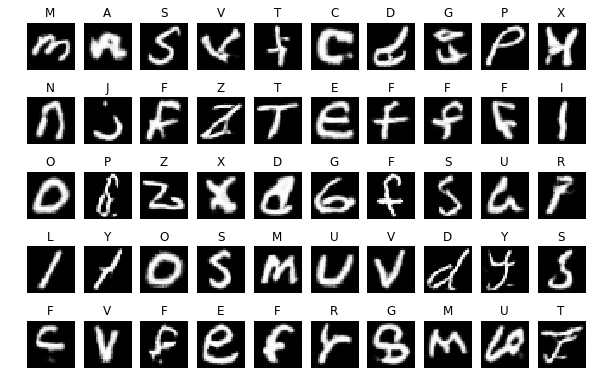

Epoch: 24, G-Loss: 1.6128463267592945, D-Loss-Real: 0.4578739068006576, D-Loss-Fake: 0.42749716047337144


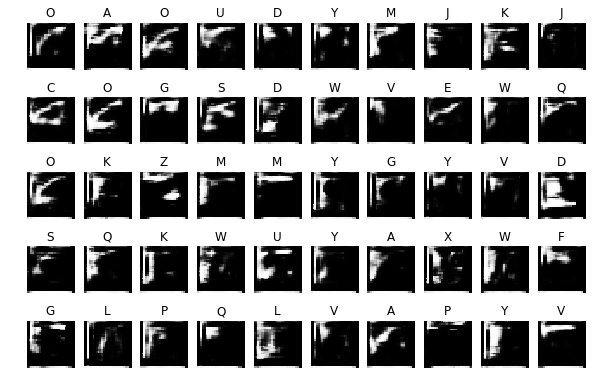

Epoch: 25, G-Loss: 1.6271219640025487, D-Loss-Real: 0.4774625354180762, D-Loss-Fake: 0.45073273017873683


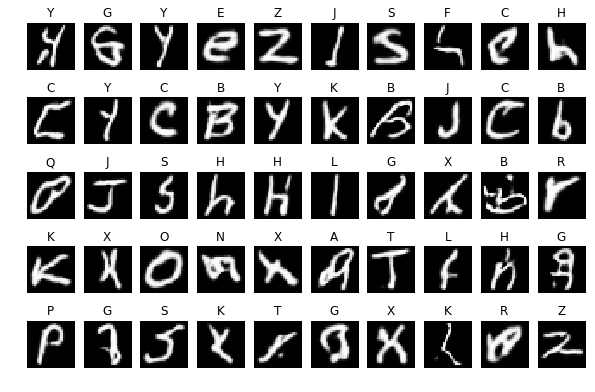

Epoch: 26, G-Loss: 1.5020393541120314, D-Loss-Real: 0.5143454284205904, D-Loss-Fake: 0.4944772603961851


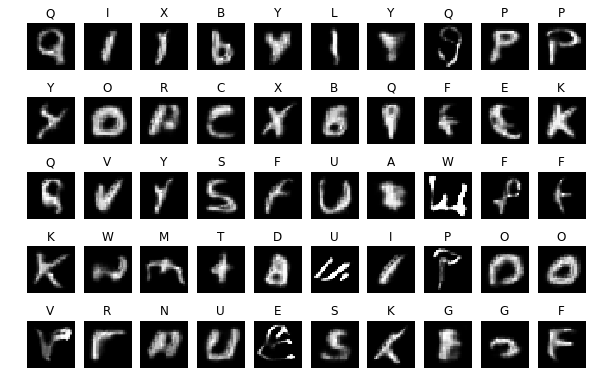

Epoch: 27, G-Loss: 1.558083341599198, D-Loss-Real: 0.49242429686468686, D-Loss-Fake: 0.47157696894335127


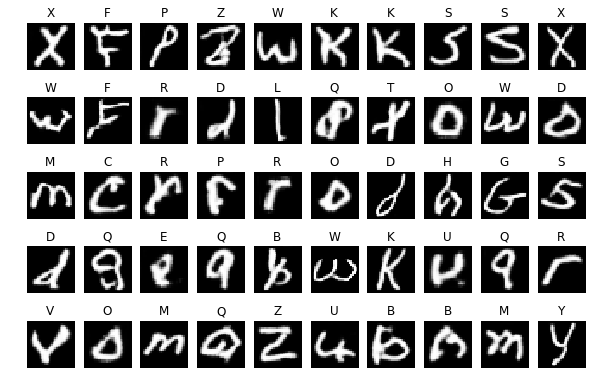

Epoch: 28, G-Loss: 1.4819936737718775, D-Loss-Real: 0.5162999987258692, D-Loss-Fake: 0.4981616379891761


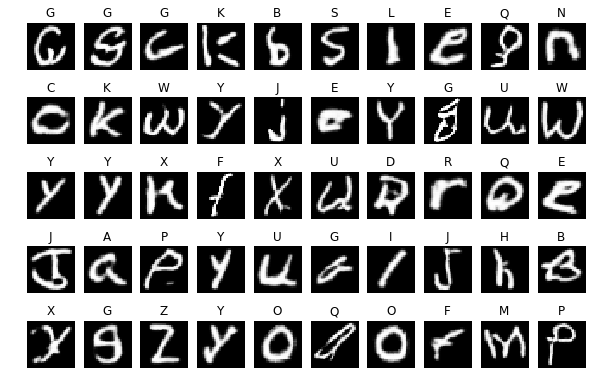

Epoch: 29, G-Loss: 1.500688862388347, D-Loss-Real: 0.5134554808739283, D-Loss-Fake: 0.4970255361639114


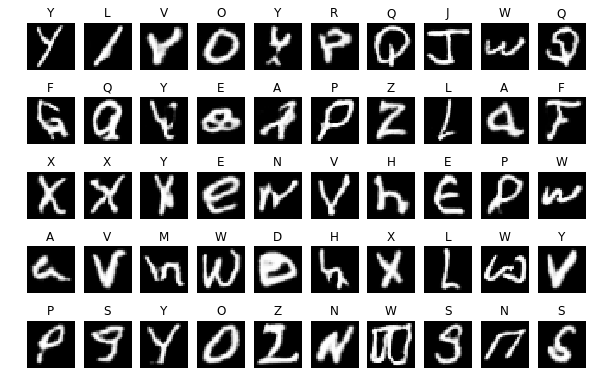

Epoch: 30, G-Loss: 1.499836096588404, D-Loss-Real: 0.5116808519669156, D-Loss-Fake: 0.4930547667339831


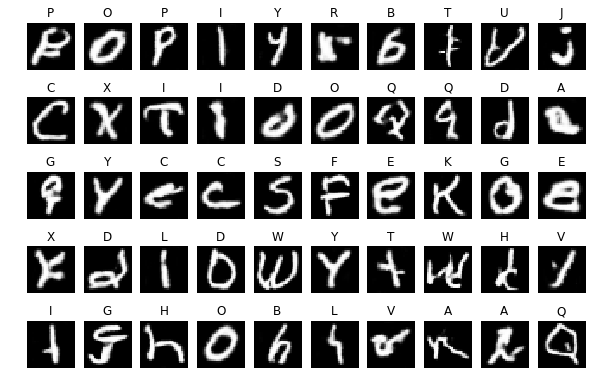

Epoch: 31, G-Loss: 1.4967748213570125, D-Loss-Real: 0.5097368040071097, D-Loss-Fake: 0.4933269423907703


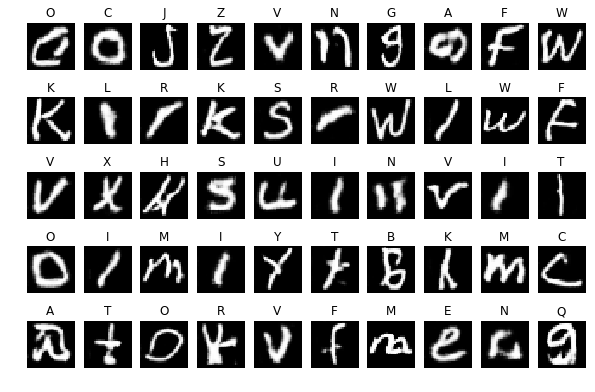

Epoch: 32, G-Loss: 1.5009498990406565, D-Loss-Real: 0.5107269957876343, D-Loss-Fake: 0.49107761477101436


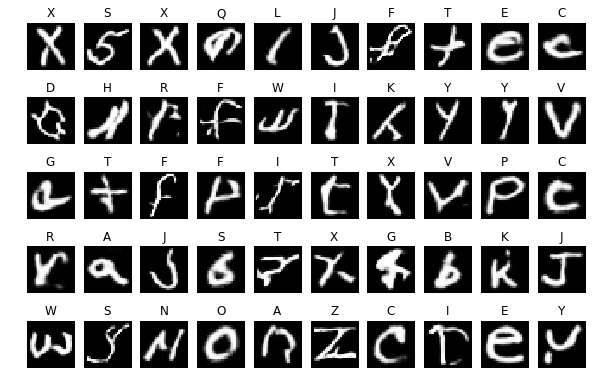

Epoch: 33, G-Loss: 1.5100922742563296, D-Loss-Real: 0.5064012240994217, D-Loss-Fake: 0.4866775274062019


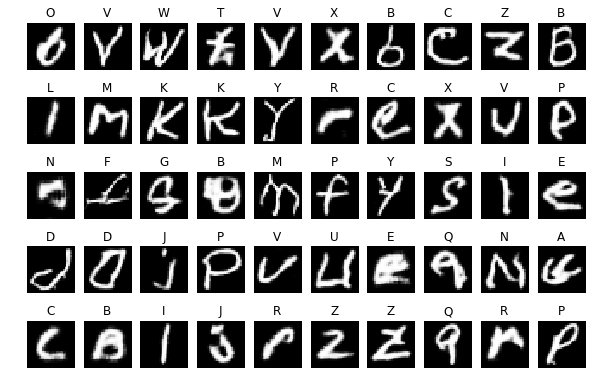

Epoch: 34, G-Loss: 1.534069246105227, D-Loss-Real: 0.5035332900818212, D-Loss-Fake: 0.4846720155704262


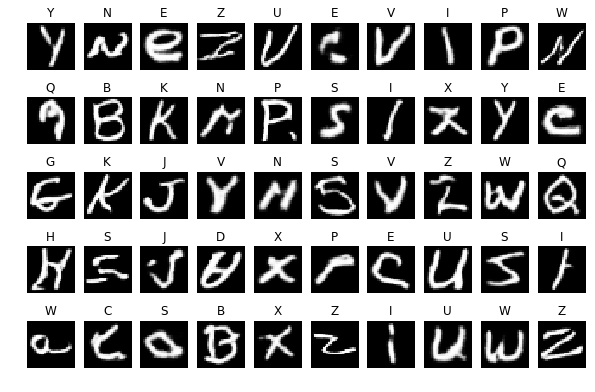

Epoch: 35, G-Loss: 1.5208527022376872, D-Loss-Real: 0.5039667563797418, D-Loss-Fake: 0.48556724160652


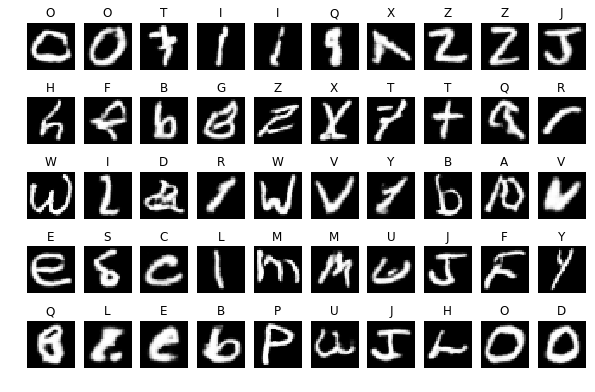

Epoch: 36, G-Loss: 1.5246980194571382, D-Loss-Real: 0.5042195360710366, D-Loss-Fake: 0.4837125309391393


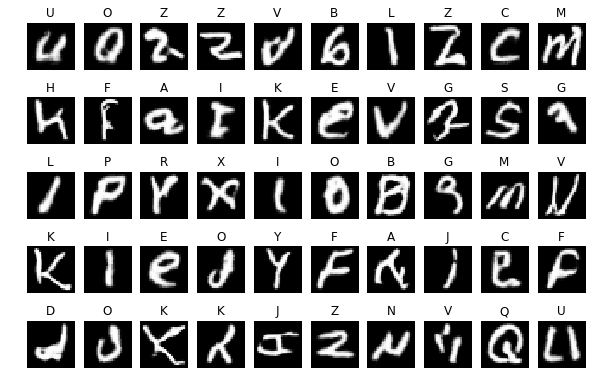

Epoch: 37, G-Loss: 1.5448863642016475, D-Loss-Real: 0.5010345101528277, D-Loss-Fake: 0.4827495440411293


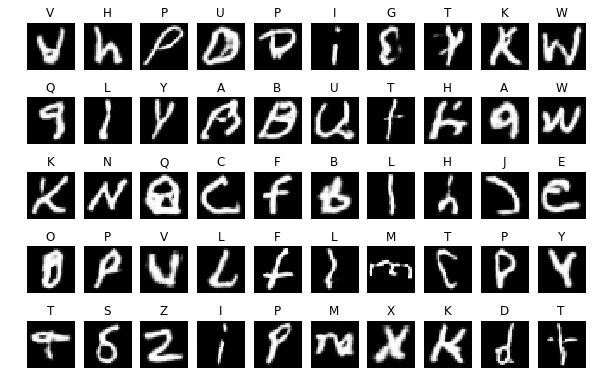

Epoch: 38, G-Loss: 1.5479977884965945, D-Loss-Real: 0.5010841362586282, D-Loss-Fake: 0.47996211870001787


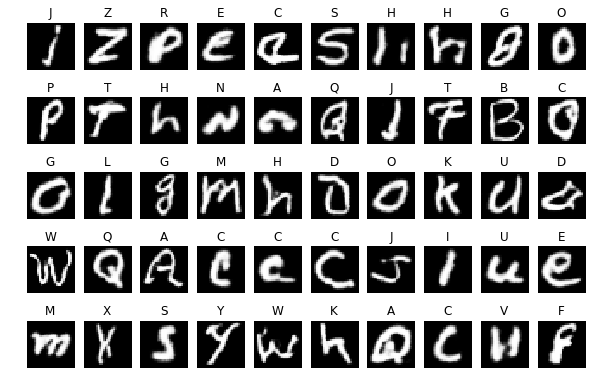

Epoch: 39, G-Loss: 1.550387619294076, D-Loss-Real: 0.49747289019376467, D-Loss-Fake: 0.48033903144106743


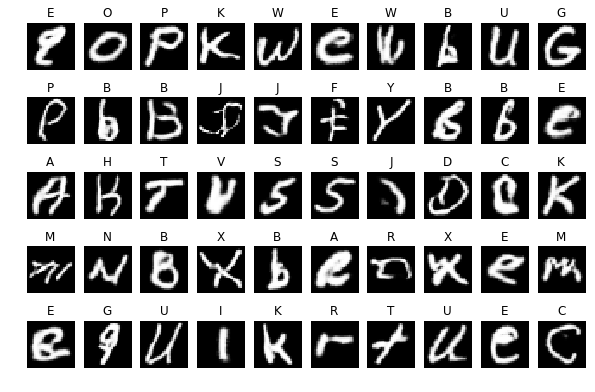

In [10]:
D_losses_fake = np.zeros((N_EPOCHS,))
D_losses_real = np.zeros((N_EPOCHS,))
G_losses = np.zeros((N_EPOCHS,))

for epoch in range(N_EPOCHS):
    for batch in range(N_BATCHES):        
        # get real data and the corresponding conditional vectors
        if batch == N_BATCHES-1:
            X_real = Xs_real[-BATCH_SIZE:]
            conditions = ys_real[-BATCH_SIZE:]
        else:
            X_real = Xs_real[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
            conditions = ys_real[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
        conditions = onehot_encoding(conditions)

        # train discriminator on real data
        labels_real = generate_labels("real", 0.1)
        D_loss_real = D.train_on_batch([X_real, conditions], labels_real)
        
        # train discriminator on fake data
        Z_fake = generate_random_Z_noise(BATCH_SIZE)
        X_fake = G.predict([Z_fake, conditions])
        labels_fake = generate_labels("fake", 0.1)
        D_loss_fake = D.train_on_batch([X_fake, conditions], labels_fake)
        
        # train generator with labels for real data
        Z_fake = generate_random_Z_noise(BATCH_SIZE)
        labels_real = generate_labels("real", 0)
        G_loss = cgan.train_on_batch([Z_fake, conditions], labels_real)
        
        # handle the loss
        D_losses_real[epoch] += D_loss_real
        D_losses_fake[epoch] += D_loss_fake
        G_losses[epoch] += G_loss
    
    D_losses_real[epoch] /= N_BATCHES
    D_losses_fake[epoch] /= N_BATCHES
    G_losses[epoch] /= N_BATCHES
    print("Epoch: {}, G-Loss: {}, D-Loss-Real: {}, D-Loss-Fake: {}"
          .format(epoch, G_losses[epoch], D_losses_real[epoch], D_losses_fake[epoch]))
    show_progress(epoch)
    save_progress(epoch)

# Evaluation

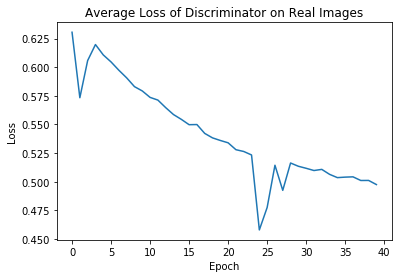

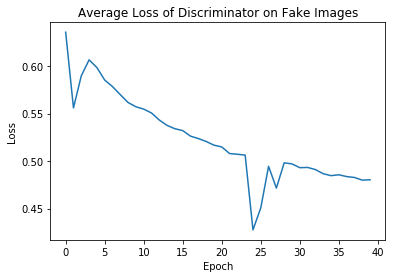

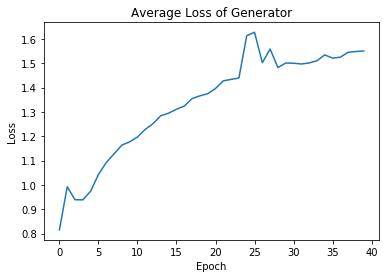

In [12]:
# Plotting the discriminator losses on real images
plt.plot(D_losses_real)
plt.title("Average Loss of Discriminator on Real Images")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(IMAGES_PATH + "D_Losses_Real.png")
plt.show()

# Plotting the discriminator losses on fake images
plt.plot(D_losses_fake)
plt.title("Average Loss of Discriminator on Fake Images")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(IMAGES_PATH + "D_Losses_Fake.png")
plt.show()

# Plotting the generator losses
plt.plot(G_losses)
plt.title("Average Loss of Generator")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(IMAGES_PATH + "G_Losses.png")
plt.show()

/home/student/anaconda3/envs/dml_gpu/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


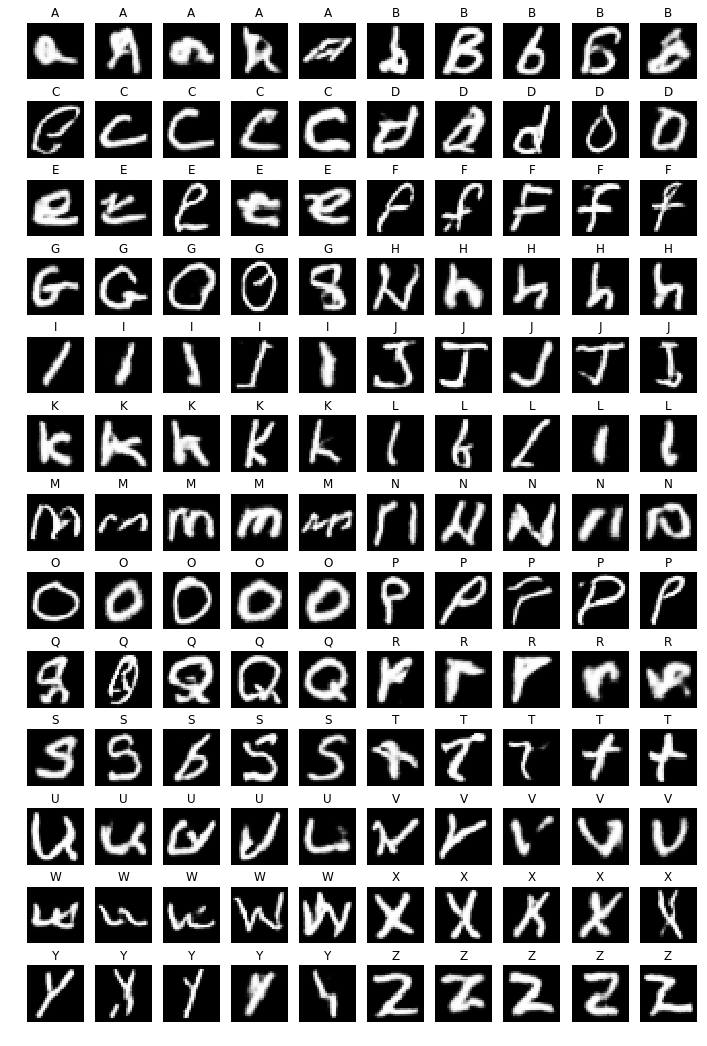

In [14]:
N_SAMPLES_PER_CLASS = 5
nrows = int(N_CLASSES / 2)
ncols = N_SAMPLES_PER_CLASS * 2

def show_test(images, conditions):
    targets = [letters_map[c] for c in conditions]
    fig = plt.figure(figsize=(12, 14))
    plt.subplots_adjust(bottom=0, top=1)
    
    for index in range(nrows*ncols):
        plt.subplot(nrows, ncols, index+1)
        image = images[index].reshape(IMAGE_SIZE, IMAGE_SIZE)
        plt.imshow(image, cmap="gray")
        plt.title(targets[index])
        plt.axis("off")
    plt.savefig(IMAGES_PATH + "test.png")
    plt.show()
    
def test():  
    G = load_model(MODELS_PATH + "G_epoch39.h5")
    conditions = np.array([i for i in range(N_CLASSES)])
    conditions = np.repeat(conditions, N_SAMPLES_PER_CLASS)
    onehot_conditions = onehot_encoding(conditions)
    
    Z_noise = generate_random_Z_noise(len(conditions))
    images = G.predict([Z_noise, onehot_conditions])
    show_test(images, conditions)
    
test()